In [367]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd



In [368]:

import json

with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_12_rocks_allWalks.json", "r") as f:
    data = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_12_rocks_allWalks.json", "w") as f:
    json.dump(data,f)



In [369]:
framerate = data['framerate']

In [370]:
data.keys()

dict_keys(['ww', 'splitWalks_date', 'walkType', 'eyes', 'frames', 'sessionID', 'takeID', 'subID', 'shadowMarkerNames', 'processData_date', 'framerate', 'legLength', 'calibDist', 'px2mmScale', 'rVorCalibErr', 'comXYZ', 'isThisVORCalibrationData', 'rGazeGroundIntersection', 'rEyeballCenterXYZ', 'rGazeXYZ', 'headVecX_fr_xyz', 'headVecY_fr_xyz', 'headVecZ_fr_xyz', 'shadow_fr_mar_dim', 'rHeelXYZ', 'rToeXYZ', 'rFootXYZ', 'lHeelXYZ', 'lToeXYZ', 'lFootXYZ', 'hTopXYZ', 'headXYZ', 'hCenXYZ', 'steps_HS_TO_StanceLeg_XYZ', 'syncedUnixTime', 'gaze_norm_pos_x', 'gaze_norm_pos_y', 'worldFrameIndex', 'headGlobalQuat_wxyz', 'rEye_theta', 'rEye_phi', 'rEye_norm_pos_x', 'rEye_norm_pos_y', 'rEye_circle_3d_radius', 'rEye_blinks', 'sesh', 'rCorrAlignTheta', 'corrAlignTheta'])

In [371]:
frames = np.array(data['frames'])
time = np.array(data['syncedUnixTime'])
time = time -time[0]


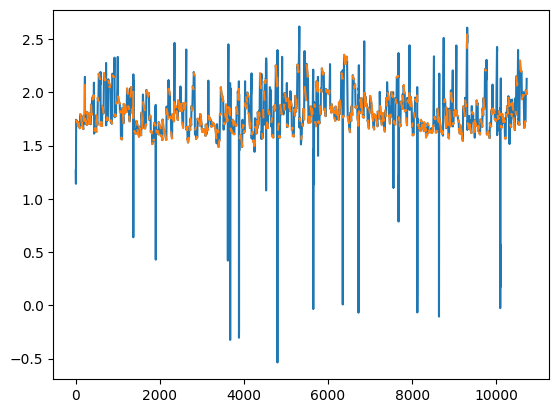

In [372]:
fixation = np.array(data['rEye_blinks'], dtype = bool)
theta = np.array(data['rEye_theta'])
phi = np.array(data['rEye_phi'])
theta_fix = np.array(data['rEye_theta'])
theta_fix[fixation] = np.nan


plt.plot(theta)
plt.plot(theta_fix)

In [373]:
fixations_df = pd.DataFrame({ 'Frames': frames, 'Time': time, 'Theta': theta,
                             'ThetaFix': theta_fix})

fixations_df = fixations_df.dropna()
fixations_df['TimeDiffPrev'] = fixations_df['Time'].diff()
fixations_df['TimeDiffFol'] = fixations_df['Time'].diff(periods=-1)

FixEnd = fixations_df.loc[fixations_df['TimeDiffPrev'] > 0.009]
FixStart = fixations_df.loc[fixations_df['TimeDiffFol'] < -0.009]

In [374]:
steps = np.array(data['steps_HS_TO_StanceLeg_XYZ']) #frame step start, frame step end, left/right, XYZ
step_start = steps[:,0].astype(int)
step_start_time = step_start / framerate

step_end = steps[:,1].astype(int)
step_end_time = step_end / framerate

step_frames = steps[:,0:2].astype(int)
step_time = step_frames.T / framerate


In [375]:
steps[0:8,2]

array([2., 1., 2., 1., 2., 1., 2., 1.])

In [376]:
steps_df = pd.DataFrame({'FrameStart': steps[:,0], 'FrameEnd': steps[:,1], 'Foot':steps[:,2],
                         'X': steps[:,3],  'Y': steps[:,4],  'Z' :steps[:,5]})

steps_df['StartTime'] = step_start_time
steps_df['EndTime'] = step_end_time

right_foot = steps_df.loc[(steps_df['Foot'] == 2)]
left_foot = steps_df.loc[(steps_df['Foot'] == 1)]

In [377]:
steps_df

,FrameStart,FrameEnd,Foot,X,Y,Z,StartTime,EndTime
0,19.0,30.0,2.0,328.890184,54028.169862,34.876973,0.158333,0.250000
1,74.0,86.0,1.0,702.596362,53983.003198,-138.366129,0.616667,0.716667
2,138.0,154.0,2.0,1097.389802,53953.016805,-172.828013,1.150000,1.283333
3,205.0,217.0,1.0,1541.526066,53878.893967,-320.770831,1.708333,1.808333
4,271.0,296.0,2.0,1949.974564,53858.080389,-260.215106,2.258333,2.466667
...,...,...,...,...,...,...,...,...
133,10456.0,10467.0,1.0,52180.066992,60747.337912,-385.354139,87.133333,87.225000
134,10515.0,10521.0,2.0,52700.631330,60686.046680,-261.912358,87.625000,87.675000
135,10576.0,10595.0,1.0,53473.226188,60777.067971,-125.332345,88.133333,88.291667
136,10647.0,10662.0,2.0,53905.026003,60826.335645,8.251712,88.725000,88.850000


(0.0, 1.6)

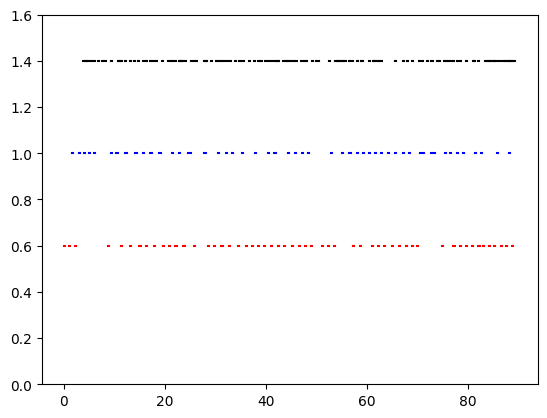

In [378]:
plt.plot((FixStart['Time'][3:], FixEnd['Time'][3:]), np.full_like((FixStart['Time'][3:],FixEnd['Time'][3:]),
                                                                           1.4, dtype=float), color = 'black')  

plt.plot((left_foot['StartTime'],left_foot['EndTime']), np.ones_like((left_foot['StartTime'],left_foot['EndTime'])), color = 'blue')
plt.plot((right_foot['StartTime'],right_foot['EndTime']), np.full_like((right_foot['StartTime'],right_foot['EndTime']),
                                                                            0.6, dtype=float), color = 'red')                                                       
plt.ylim(0,1.6)   

In [394]:
fixStart = np.array(FixStart['Time'])
fixEnd = np.array(FixEnd['Time'])
footfalls=np.array(steps_df['StartTime'])

footfalls = footfalls.reshape(-1,1)
fixStart = fixStart.reshape(-1,1)
fixStop = fixEnd.reshape(-1,1)

from sklearn.neighbors import NearestNeighbors

X = footfalls
neigh = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)

Start = fixStart 
Stop = fixStop

start_distances, start_indices = neigh.kneighbors(Start)
stop_distances, stop_indices = neigh.kneighbors(Stop)

startNearest = np.array(start_indices)
stopNearest = np.array(stop_indices)

In [396]:
start_times_f = footfalls[start_indices]
stop_times_f = footfalls[stop_indices]
start_times_f = start_times_f[:,0]
stop_times_f = stop_times_f[:,0]

df = pd.DataFrame(start_times_f, columns = ['startFoot'])
df['stopFoot'] = stop_times_f
df['startNearest'] = startNearest
df['stopNearest'] = stopNearest
#df['Start'] = FixStart.loc[1:, ['Time']]
#df['Stop'] = FixEnd['Time']

In [397]:
df

,startFoot,stopFoot,startNearest,stopNearest
0,0.616667,0.616667,1,1
1,0.616667,1.150000,1,2
2,1.150000,1.150000,2,2
3,1.708333,1.708333,3,3
4,1.708333,1.708333,3,3
...,...,...,...,...
292,88.133333,88.133333,135,135
293,88.133333,88.133333,135,135
294,88.133333,88.725000,135,136
295,88.725000,88.725000,136,136


In [404]:
footfalls_ar = np.array(footfalls)
fmax = footfalls_ar.max()
fmin = footfalls_ar.min()


NormStart = np.array(df['startFoot'].copy())
minmaxnorm = []

for x in NormStart:
    y = ((x - fmin) / (fmax - fmin))
    minmaxnorm.append(y)

df['NormStart'] = minmaxnorm


In [405]:
NormStop = np.array(df['stopFoot'].copy())
minmaxnorm_stop = []
# start and stop have the same min and max
for x in NormStop:
    y = ((x - fmin) / (fmax - fmin))
    minmaxnorm_stop.append(y)

df['NormStop'] = minmaxnorm_stop

In [407]:
df

,startFoot,stopFoot,startNearest,stopNearest,NormStop,NormStart
0,0.616667,0.616667,1,1,0.005143,0.005143
1,0.616667,1.150000,1,2,0.011128,0.005143
2,1.150000,1.150000,2,2,0.011128,0.011128
3,1.708333,1.708333,3,3,0.017393,0.017393
4,1.708333,1.708333,3,3,0.017393,0.017393
...,...,...,...,...,...,...
292,88.133333,88.133333,135,135,0.987189,0.987189
293,88.133333,88.133333,135,135,0.987189,0.987189
294,88.133333,88.725000,135,136,0.993828,0.987189
295,88.725000,88.725000,136,136,0.993828,0.993828


(array([30., 27., 30., 28., 31., 30., 35., 28., 29., 29.]),
 array([0.00514307, 0.10462876, 0.20411446, 0.30360015, 0.40308584,
        0.50257154, 0.60205723, 0.70154292, 0.80102861, 0.90051431,
        1.        ]),
 <BarContainer object of 10 artists>)

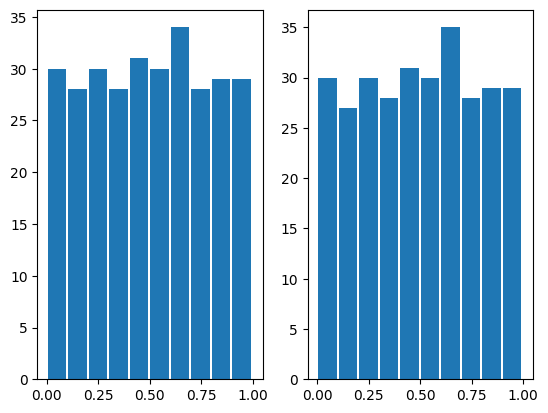

In [418]:
plt.subplot(1,2,1)
plt.hist(df['NormStart'], width = 0.09)
plt.subplot(1,2,2)
plt.hist(df['NormStop'], width = 0.09)

<Axes: xlabel='NormStart', ylabel='Density'>

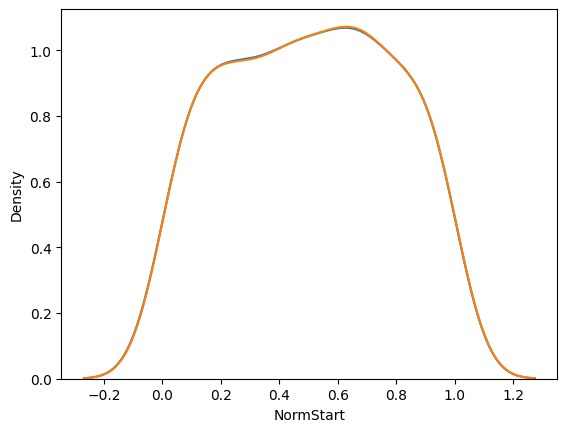

In [417]:
import seaborn as sns

sns.kdeplot(data=df, x='NormStart')
sns.kdeplot(data=df, x='NormStop')

(array([ 6., 11., 36., 57., 60., 60., 45., 17.,  3.,  2.]),
 array([-0.5583333 , -0.43583331, -0.31333331, -0.19083332, -0.06833333,
         0.05416667,  0.17666666,  0.29916665,  0.42166665,  0.54416664,
         0.66666663]),
 <BarContainer object of 10 artists>)

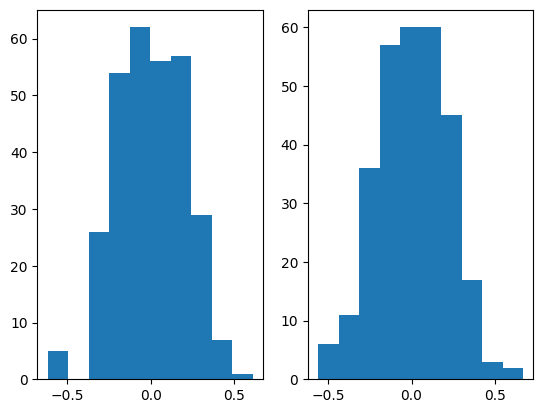

In [389]:
rel_start_time = []
rel_stop_time = []

for x, y in zip(Start,start_times_f):
    z = x - y
    rel_start_time.append(z)

for x, y in zip(Stop,stop_times_f):
    z = x - y
    rel_stop_time.append(z)

rel_start_time = np.array(rel_start_time)
rel_stop_time = np.array(rel_stop_time)


plt.subplot(1,2,1)
plt.hist(rel_start_time[:,0])


plt.subplot(1,2,2)
plt.hist(rel_stop_time[:,0])

<Axes: xlabel='RelStart', ylabel='Density'>

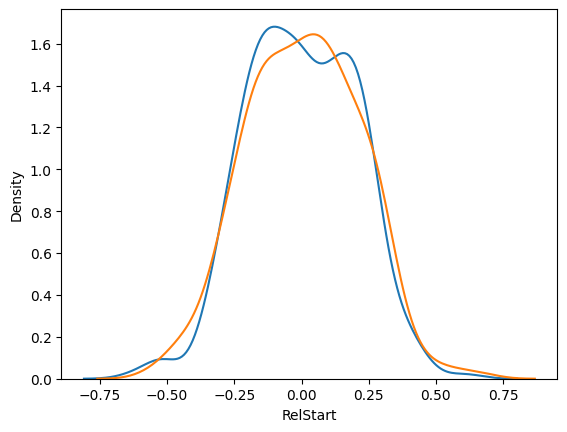

In [390]:
import seaborn as sns

rel_start_time = rel_start_time[:,0]
rel_stop_time = rel_stop_time[:,0]

RelFixTimes = pd.DataFrame(rel_start_time, columns=['RelStart'])
RelFixTimes['RelStop'] = rel_stop_time

sns.kdeplot(data=RelFixTimes, x='RelStart')
sns.kdeplot(data=RelFixTimes, x='RelStop')





In [391]:
Norm = np.array(RelFixTimes['RelStart'].copy())


minmaxNormStart = []
for x in Norm:
    y = ((x - Norm.min()) / (Norm.max() - Norm.min()))
    minmaxNormStart.append(y)



In [392]:
Norm = np.array(RelFixTimes['RelStop'].copy())

minmaxNormStop = []
for x in Norm:
    y = ((x - Norm.min()) / (Norm.max() - Norm.min()))
    minmaxNormStop.append(y)

(array([ 6., 11., 36., 57., 60., 60., 45., 17.,  3.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

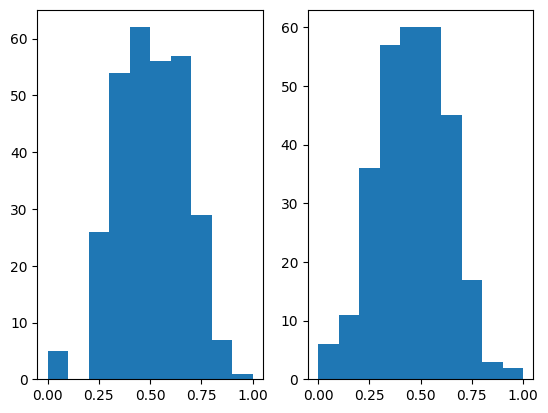

In [393]:
plt.subplot(1,2,1)
plt.hist(minmaxNormStart)
plt.subplot(1,2,2)
plt.hist(minmaxNormStop)
